In [1]:
import cirq
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt

#define utility functions

def simulate(circuit: cirq.Circuit) -> dict:
    """This funcion simulate a cirq circuit (without measurement) and output results in the format of histogram.
    """
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    
    state_vector=result.final_state_vector
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i])**2
        #if population > 1e-9:
        histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        positive+=histogram[key] #no if statement anymore
    return positive

def count_gates(circuit: cirq.Circuit):
    """Returns the number of 1-qubit gates, number of 2-qubit gates, number of 3-qubit gates...."""
    counter=Counter([len(op.qubits) for op in circuit.all_operations()])
    
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)


In [2]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)



{False, True}
2000
2000
True
[0.         0.         0.         0.01960784 0.01960784 0.01960784
 0.03529412 0.         0.29803922 0.76862745 0.80784314 0.82352941
 0.83529412 0.83921569 0.84705882 0.83137255 0.97254902 0.95686275
 0.78823529 0.77254902 0.78431373 0.21176471 0.         0.04705882
 0.01960784 0.01960784 0.         0.        ]


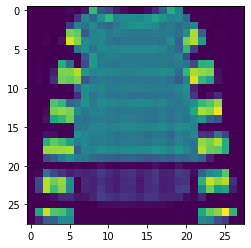

In [3]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
print(set(labels))
print(len(labels))
print(len(images))

print(labels[80])
print(images[1][25]*255)

#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[80])

In [4]:
#submission to part 1, you should make this into a .py file

n=len(dataset)
mse=0
gatecount=0

def encode(image):
    circuit=cirq.Circuit()
    epsilon = 0.1/255 #background is sometimes not exactly 0
    
    if len(image) < 28:
        rows_to_check = [0, 1]
        qubits = cirq.LineQubit.range(4)
    else:
        rows_to_check = [1, 7, 14, 21, 26] #rows we use to get info
        qubits = cirq.LineQubit.range(2*len(rows_to_check))
    
    #test qubit
    for row in rows_to_check:
        for i in range(len(image[0])):
            if image[row][i] >= epsilon:
                circuit.append(cirq.rx(np.pi/len(image[0]))(qubits[rows_to_check.index(row)])) #should represent % non-background values for a row in rows_to_check (first |rows_to_check| qubits)
                #check amount of "segments" (between 0 and 3) in each row in rows_to_check
                if i == 0:
                    circuit.append(cirq.rx(np.pi/3)(qubits[rows_to_check.index(row)+len(rows_to_check)])) #starts with non-background e.g. [[1,1],[1,1]]
                else:
                    if image[row][i-1] < epsilon:
                        circuit.append(cirq.rx(np.pi/3)(rows_to_check.index(row)+len(rows_to_check)))
    print(circuit)
    return circuit

def encode_old(image):
    circuit=cirq.Circuit()
    if image[0][0]==0:
        circuit.append(cirq.rx(np.pi).on(cirq.LineQubit(0)))
    return circuit


def decode(histogram):
    if 1 in histogram.keys():
        image=[[0,0],[0,0]]
    else:
        image=[[1,1],[1,1]]
    return image

def run_part1(image):
    #encode image into a circuit
    circuit=encode(data['image'])

    #simulate circuit
    histogram=simulate(circuit)
    print("Histogram:")
    print(histogram)

    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re

import matplotlib.pyplot as plt



In [5]:
#how we grade your submission

n=len(dataset)
mse=0
gatecount=0

for data in dataset:
    print(data)
    #encode image into circuit
    circuit,image_re=run_part1(data['image'])
    
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    mse+=image_mse(data['image'],image_re)
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/n
print()
print("Gatecount: ", gatecount) #0 babyyyy

#score for part1 
print()
print("Score part 1: ", f*(0.999**gatecount))

{'image': [[1, 1], [1, 1]], 'category': 0}
0: ───Rx(0.5π)─────Rx(0.5π)───

1: ───Rx(0.5π)─────Rx(0.5π)───

2: ───Rx(0.333π)──────────────

3: ───Rx(0.333π)──────────────
Histogram:
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.5624998211860799, 13: 0.18749994165028117, 14: 0.18749994165028117, 15: 0.062499985098839694}
{'image': [[0, 0], [0, 0]], 'category': 1}

Histogram:
{0: 1.0}

Gatecount:  0.0

Score part 1:  -1.0
